In [8]:
## Ajoute la valeur de brisque dans le dictionnaire Python ##

from brisque import BRISQUE
from skimage.io import imread
import os
import json

with open('Metadata_2018.json') as mon_fichier:
    data = json.load(mon_fichier)


for i in range(0,len(data)):
    filename = data[i]["isic_id"]
    brisq = BRISQUE()
    img = imread("ISIC_2018_TEST/" + filename + ".JPG")
    valeur = brisq.score(img)
    data[i]["brisque"] = valeur




In [11]:
## Importer les données dans un fichier JSON ##

import json

with open("Metadata_with_BRISQUE.json", "w") as f:
    json.dump(data, f, indent = 4)

In [ ]:
## Permet de créer une liste de valeur du BRISQUE ##

import json 

with open('Metadata_with_BRISQUE.json') as mon_fichier:
    data = json.load(mon_fichier)

brisques = []

for i in range(0,len(data)):
    valeur = data[i]["brisque"]
    brisques.append(valeur)

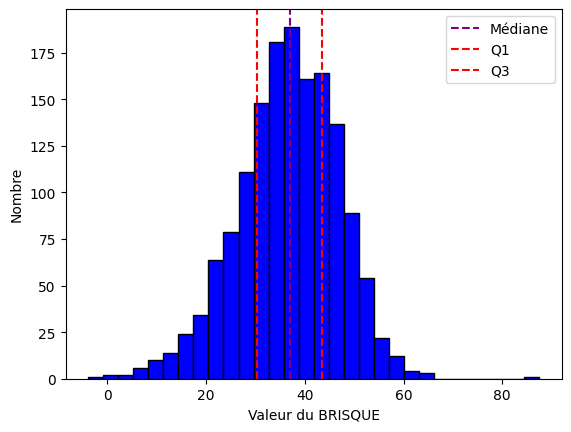

In [29]:
## Affiche la répartition des valeurs du BRISQUE pour les images ##

import matplotlib.pyplot as plt
import numpy as np

mediane = np.median(brisques)

Q1 = np.percentile(brisques, 25)
Q3 = np.percentile(brisques, 75)


plt.axvline(x=mediane, color = "purple", linestyle = "--",  label = "Médiane")
plt.axvline(x= Q1, color = "red", linestyle = "--", label = "Q1")
plt.axvline(x = Q3, color = "red", linestyle = "--",  label = "Q3")
plt.hist(brisques, bins = 30, color = "blue", edgecolor = "black")
plt.xlabel("Valeur du BRISQUE")
plt.ylabel('Nombre')
plt.legend()
plt.show()

In [6]:
## Images avec un brisque <10 ##

import json 

with open('Metadata_with_BRISQUE.json') as mon_fichier:
    data = json.load(mon_fichier)



for i in range(0,len(data)):
    valeur = data[i]["brisque"]
    if valeur < 10:
        print(data[i]["isic_id"])

ISIC_0035068
ISIC_0035133
ISIC_0035156
ISIC_0035187
ISIC_0035235
ISIC_0035665
ISIC_0035938
ISIC_0036005


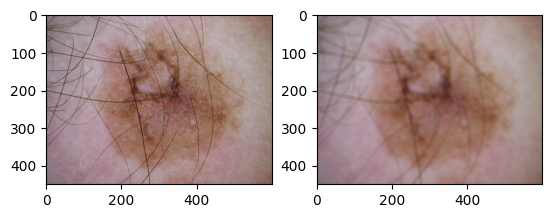

In [41]:
## Application d'un filtre gaussien pour flouter l'image ##

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2

img = imread("ISIC_2018_TEST/ISIC_0035803.JPG")
img2 = cv2.blur(img, (10, 10))
img3 = cv2.medianBlur(img, 3)
img4 = cv2.GaussianBlur(img, (5, 5), 3)
#img5 = cv2.filter2D(img, -1, np.array([[1 for i in range(3)] for j in range(3)], dtype = np.float) / 9)
fig=plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(img2)


plt.show()

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def convertWithMask(file):
    # Read the image and perfrom an OTSU threshold
    fichier = 'ISIC_2018_TEST/' + file
    img = cv2.imread(fichier)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Remove hair with opening
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    # Combine surrounding noise with ROI
    kernel = np.ones((6,6),np.uint8)
    dilate = cv2.dilate(opening,kernel,iterations=3)

    # Blur the image for smoother ROI
    blur = cv2.blur(dilate,(15,15))

    # Perform another OTSU threshold and search for biggest contour
    ret, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea)

    # Create a new mask for the result image
    h, w = img.shape[:2]
    mask = np.zeros((h, w), np.uint8)

    # Draw the contour on the new mask and perform the bitwise operation
    cv2.drawContours(mask, [cnt],-1, 255, -1)
    res = cv2.bitwise_and(img, img, mask=mask)

    # Display the result
    cv2.imwrite('ISIC_2018_Mask/' + file, res)

folder = os.listdir("ISIC_2018_TEST/")
folder2 = os.listdir("ISIC_2018_Mask/")

iterations = 0
for file in folder2 :
    iterations = iterations + 1

print(iterations)

for file in folder:
    if file not in folder2 :
        print(file)
        convertWithMask(file)


1512


In [34]:
from PIL import Image

## Découpe les photos pour ne garder que le mélanome.


def convertImage(file):
    img = Image.open("ISIC_2018_Mask/" + file)
    img = img.convert("RGBA")
 
    datas = img.getdata()
 
    newData = []
 
    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 0:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
 
    img.putdata(newData)
    img.save("ISIC_2018_Transparent/" + file, "PNG")


folder = os.listdir("ISIC_2018_Mask/")

for file in folder:
    convertImage(file)